In [ ]:
!unzip ea


In [2]:
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 10, 10

def plotmodel(history,name):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lrs = history.history['lr']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,acc)#mooth_curve(acc))
    plt.plot(epochs,val_acc)#smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs, loss)#smooth_curve(loss))
    plt.plot(epochs,val_loss)#smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')
    
    plt.figure(3)
    plt.plot(epochs,lrs)
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.legend(['lr'], loc='upper right')
    plt.savefig('lr_'+name+'.png')


Found 416 images belonging to 26 classes.
Found 104 images belonging to 26 classes.
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 3600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 26)                93626     
Total params: 93,626
Trainable params: 93,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
416/416 [==============================] - 2s 3ms/step - loss: 1081.4152 - accuracy: 0.2256 - val_loss: 335.7077 - val_accuracy: 0.6827

Epoch 00001: val_loss improved from inf to 335.70767, saving model to best.hdf5
Epoch 2/10
416/416 [==============================] - 1s 3ms/step - loss: 214.1835 - accuracy: 0.8127 - val_loss: 89.9060 - val_accuracy: 0.8846

Epoch 00002: val_loss improved from 335.70767 to 89.9

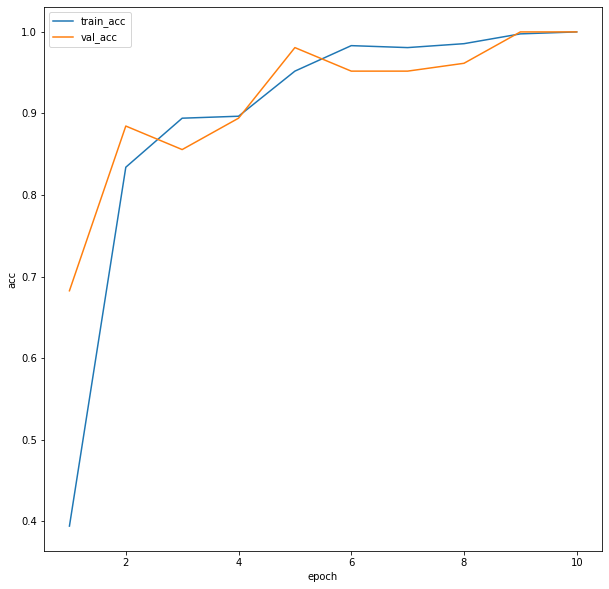

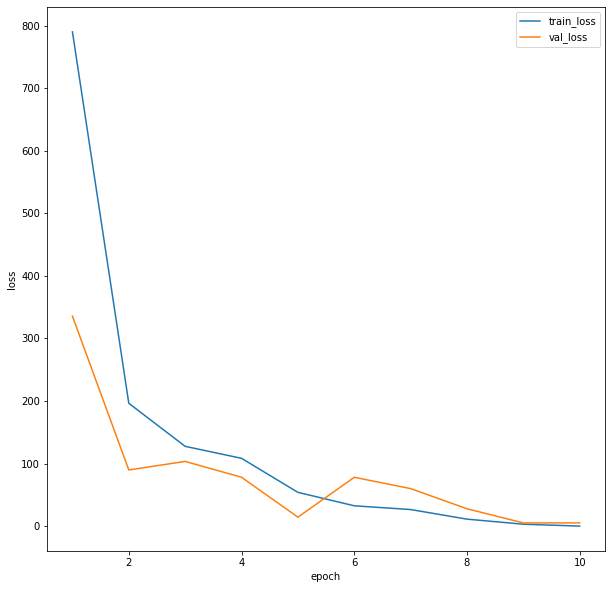

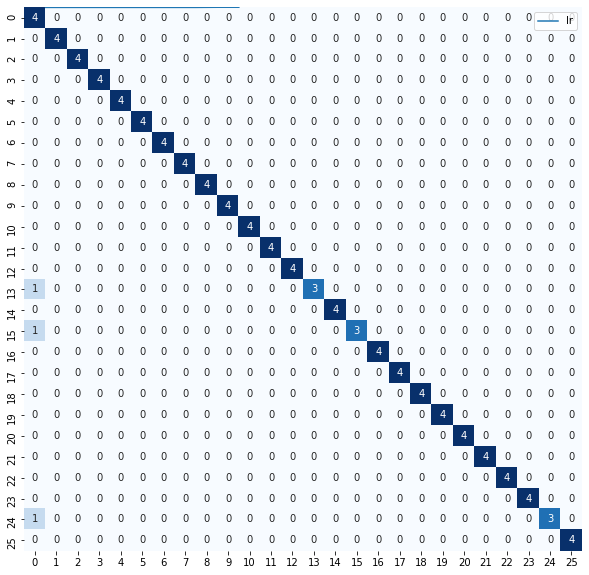

In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from keras.activations import softmax, sigmoid
from keras.layers import Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

batch_size = 1

# def to_bipolar(img):
#   img[img==0] = -1
#   img[img>0] = +1
#   return img
datagen = ImageDataGenerator(
    # preprocessing_function=to_bipolar,
    validation_split=0.2
    )

train = datagen.flow_from_directory(
        'ea',
        target_size=(60, 60),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True,
        subset='training'
    )

test = datagen.flow_from_directory(
        'ea',
        target_size=(60, 60),
        color_mode="grayscale",
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False,
        subset= 'validation'
    )


weight_path="best.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=1, min_lr=0.00001)
callbacks_list = [checkpoint, reduceLROnPlat]

model = Sequential()
model.add(Input(shape=(60,60)))
model.add(Flatten())
model.add(Dense(26, activation=sigmoid, kernel_initializer='glorot_uniform'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

history = model.fit(train, validation_data=test, epochs=10, callbacks=callbacks_list )

plotmodel(history,'perceptron')
model.load_weights('best.hdf5')
model.save('full_model.h5')
pred= model.predict(test, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

sns.heatmap(confusion_matrix(test.labels, predicted_class_indices), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test.labels, predicted_class_indices)))
print(classification_report(test.labels, predicted_class_indices))

In [2]:

import pandas as pd
import numpy as np
from os import walk
from os.path import join
import cv2
import random

class DataReader:

  def __init__(self, path):
    self.path = path
  
  def preprocess(self, img):
    img[img<255] = -1
    img[img==255] = +1
    return img
  
  def get_files_path(self):
    files = {}
    for i, w in enumerate(walk(self.path)):
      if i == 0:
        continue
      dirpath, dirnames, filenames = w
      files[i] = []
      for f in filenames:
        files[i].append(join(dirpath, f))
    return files


  def read_normal(self):
    files = self.get_files_path()
    data = pd.DataFrame({'img': [], 'label': []})
    i = 0
    for k in files.keys():
      for path in files[k]:
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = img.astype('float32')
        img = np.array(img) 
        row = pd.DataFrame({'img': [np.ndarray.flatten(img)],'path':[path] ,'label': [int(k)-1]})
        data = pd.concat([data,row], ignore_index = True)
    data['label'] = pd.to_numeric(data['label'], downcast='integer')
    data['id'] = data.index
    return data


In [3]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

reader = DataReader('/content/ea')
data = reader.read_normal()
data['label_hot'] = data['label'].map(lambda x: to_categorical(x, 1+data['label'].max()))
# data['label_hot'] = data['label_hot'].map(lambda x: list(map(lambda y: -1.0 if y == 0 else y, x)))
train_ids, valid_ids = train_test_split(data['id'], test_size = 0.25, 
                                   random_state = 2020,
                                   stratify = data['label'])
train = data[data['id'].isin(train_ids)]
train = train.sample(frac=1).reset_index(drop=True)
valid = data[data['id'].isin(valid_ids)]
print('train', train.shape[0], 'valid', valid.shape[0])
x_train = train['img'].to_numpy()
y_train = train['label_hot'].to_numpy()
x_test = valid['img'].to_numpy()
y_test = valid['label_hot'].to_numpy()
data['label'] = data['label'].astype(str)
data = data.sample(frac=1).reset_index(drop=True)
data.sample(3)

train 390 valid 130


,img,label,path,id,label_hot
68,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...",19,/content/ea/23/2.png,388,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
444,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...",3,/content/ea/4/4.png,65,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
252,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...",17,/content/ea/22/4.png,345,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [96]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from keras.activations import softmax, sigmoid
from keras.layers import Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix


def train(train, test):
  batch_size = 1
  train_datagen = ImageDataGenerator()\
  .flow_from_dataframe(
          dataframe=train,
          target_size=(60, 60),
          color_mode="grayscale",
          x_col='path',
          y_col='label',
          class_mode="categorical",
          batch_size=batch_size,
          shuffle=True)
  test_datagen = ImageDataGenerator()\
  .flow_from_dataframe(
          dataframe=test,
          target_size=(60, 60),
          color_mode="grayscale",
          x_col='path',
          y_col='label',
          class_mode="categorical",
          batch_size=batch_size,
          shuffle=False)
  reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=1, min_lr=0.00001)
  callbacks_list = [reduceLROnPlat]

  model = Sequential()
  model.add(Input(shape=(60,60)))
  model.add(Flatten())
  model.add(Dense(26, activation=sigmoid, kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
  
  history = model.fit(train_datagen, validation_data=test_datagen, verbose=0 ,epochs=10, callbacks=callbacks_list )
  
  return max(history.history['accuracy'])



In [ ]:
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
result = []
for i, d in data.iterrows():
  train_d = data[data['id'] != d['id']]
  test_d = data[data['id'] == d['id']]
  result.append(train(train_d, test_d))

print("Mean Accuracy for LOOCV : ", sum(result)/len(result))

Streaming output truncated to the last 5000 lines.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00026999999536201356.
Found 519 validated image filenames belonging to 26 classes.
Found 1 validated image filenames belonging to 1 classes.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00026999999536201356.
Found 519 validated image filenames belonging to 26 classes.
Found 1 validated image filenames belonging to 1 classes.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0

In [44]:

import pandas as pd
import numpy as np
from os import walk
from os.path import join
import cv2
import random
from math import floor
class DataReader:

  def __init__(self, path):
    self.path = path
  
  def preprocess(self, img):
    img[img<255] = -1
    img[img==255] = +1
    return img
  
  def get_files_path(self):
    files = {}
    for i, w in enumerate(walk(self.path)):
      if i == 0:
        continue
      dirpath, dirnames, filenames = w
      files[i] = []
      for f in filenames:
        files[i].append(join(dirpath, f))
    return files

  def read_normal(self, dpath='ea', size=[64, 64]):
    images = []
    image_labels = []
    dirs = os.listdir(dpath)    
    c = len(dirs)
    for _dir in dirs:
        for file in glob.glob(dpath + '/' + _dir + '/*.png'):
            images.append(np.ravel(np.array(  Image.open(file).convert('L')  )).astype(int))
            image_labels.append(int(_dir))
    images = np.array(images)
    image_labels = np.array(image_labels)
    return images, image_labels, c

  def read_noisy(self, dpath='ea', size=[64, 64], noise=0.15):
    images = []
    image_labels = []
    dirs = os.listdir(dpath)    
    c = len(dirs)
    for _dir in dirs:
        for file in glob.glob(dpath + '/' + _dir + '/*.png'):
            images.append(np.ravel(np.array(  Image.open(file).convert('L')  )).astype(int))
            image_labels.append(int(_dir))
    images = [add_noise(img, noise) for img in images]
    images = np.array(images)
    image_labels = np.array(image_labels)
    return images, image_labels, c


def add_noise(img, percent):
    num_of_pixels = floor(percent * img[img==0].size)
    b = np.where(img==0)[0]
    indices = random.sample(range(0, b.size), num_of_pixels)
    img[b[indices]] = 255
    return img

reader = DataReader('/content/ea')
images, labels, _ = reader.read_normal(dpath='ea', size=[64, 64])
ohe = OneHotEncoder()
y_train_onehot = ohe.fit_transform(np.asmatrix(labels).T).toarray()
model = Sequential()
model.add(Dense(26, input_dim=3600, activation='sigmoid', kernel_initializer='zeros'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(images, y_train_onehot, epochs=100, verbose=0)
max(history.history['accuracy'])

1.0

In [45]:
images, labels, _ = reader.read_noisy(dpath='ea', size=[64, 64], noise=0.15)
y_test_onehot = ohe.fit_transform(np.asmatrix(labels).T).toarray()
y_pred_onehot = model.predict(images)
test_acc = accuracy_score(np.argmax(y_pred_onehot, axis=1), np.argmax(y_test_onehot, axis=1))
print('Test 15% noise acc :', test_acc)

Test 15% noise acc : 0.9519230769230769


In [46]:
images, labels, _ = reader.read_noisy(dpath='ea', size=[64, 64], noise=0.25)
y_test_onehot = ohe.fit_transform(np.asmatrix(labels).T).toarray()
y_pred_onehot = model.predict(images)
test_acc = accuracy_score(np.argmax(y_pred_onehot, axis=1), np.argmax(y_test_onehot, axis=1))
print('Test 15% noise acc :', test_acc)

Test 15% noise acc : 0.8096153846153846
